In [55]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6
from collections import Counter
import pickle

In [18]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    # initialise and raise input errors
    def __init__(self, n_arms):
        if not type(n_arms)==int:
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        
    @abstractmethod
    # raise input errors
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        if not type(context) == np.ndarray:
            raise TypeError("`context` must be numpy.ndarray")
        if not context.shape == (n_arms, n_dims):
            raise TypeError("`context` must have shape (n_arms, n_dims)")
        self.context = context

    
    @abstractmethod
    # raise input errors
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        if not (type(arm) == int or arm.dtype == 'int64'):
            raise TypeError("`arm` must be int type")
        if not (arm >= 0 and arm <= (n_arms-1)):
            raise ValueError("`arm` must be the the set {0, .., n_arms - 1}")
        if not (type(reward) == float or reward.dtype == 'float64'):
            raise TypeError("`reward` must be float type")
        if not (context.shape == (n_arms, n_dims) and context.dtype == 'float64') :
            raise TypeError("`context` must be float numpy in shape (n_events, n_arms, n_dims)")
        # get the values
        self.arm = arm
        self.reward = reward
        self.context = context



In [19]:
# load dataset here

data = np.loadtxt("./smalltraindataset.txt")
arms, rewards, contexts = data[:,0], data[:,1], data[:,2:]
arms = arms.astype(np.int64)
rewards = rewards.astype(float)
contexts = contexts.astype(float)
n_arms = len(np.unique(arms))
n_events = len(contexts)
n_dims = int(len(contexts[0])/n_arms)
contexts = contexts.reshape(n_events, n_arms, n_dims)
datadist = np.array([Counter(arms)[x] for x in np.arange(20)])
    

In [20]:
def gini(array):
    array = array + 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

# Define global functions 
def break_tie(_range):
    indices = np.argwhere(_range == np.max(_range))
    index = np.random.randint(0,len(indices))

    return indices[index][0]

def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None, rewardtype = 0):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # initialise values and raise input errors
    if not (arms.shape == (n_events,) and arms.dtype == 'int64')  :
        raise TypeError("`arms` must be integer numpy in shape (n_events,)")
    if not rewards.shape == (n_events,) and rewards.dtype == 'float64' :
        raise TypeError("`rewards` must be float numpy in shape (n_events,)")
    if not contexts.shape == (n_events, n_arms, n_dims) and rewards.dtype == 'float64' :
        raise TypeError("`contexts` must be float numpy in shape (n_events, n_arms, n_dims)")
    if n_rounds == None:        # set n_rounds to infinite number to run until all data exhausted
        n_rounds = np.inf
    elif not type(n_rounds) == int:
        raise TypeError("`n_rounds` must be integer or default 'None'")

    n_round = 0     # count the current round ; 0 indicates the first round
    R = []          # save the total payoff
    H = []          # save used historical events
    acc = np.zeros(n_events)
    # n_arms = 20
    dist = np.zeros(n_arms)
    prot = set([13, 14, 17, 18])
    psp = np.array([1,1])
    for i in range(n_events):
        if n_round == n_rounds:
            break
        arm = mab.play(contexts[i])
        if arm == arms[i]:                 # if historical data equals to chosen arm
            # R.append(rewards[i])           # append the new rewards
            dist[arm] += 1
            if arm in prot:
                psp[0] +=1
            else:
                psp[1] += 1
            pspscore = (psp[0]-psp[1])/(psp[0] + psp[1])
            
            H.append([arms[i], rewards[i], 1-gini(dist), pspscore])      # append the used events
            if rewardtype == 0:
                mab.update(arms[i], rewards[i], contexts[i])      # update the information
            elif rewardtype == 1:
                mab.update(arms[i], rewards[i]+1-gini(dist), contexts[i])      # gini reward
            else:
                mab.update(arms[i], rewards[i]+min(0, pspscore), contexts[i])      # update the information


            n_round += 1
            acc[i] = rewards[i]
        # else:
        #     H.append([arm, 0, gini(dist), (psp[0]-psp[1])/(psp[0] + psp[1])])      # append the used events


    # return rewards per play
    out = np.array(H)
        
    return out, dist, psp

In [22]:
def evaluateMab(results, dist, psp):
    print(n_events, " total lines")
    print(results.shape[0], " matches")
    print(np.mean(results[:, 1]), " Average reward")
    print(np.mean(results[:, 2]), " Average Gini Index")
    print(np.mean(results[:, 3]), " Average PSP")
    
    fig, axs = plt.subplots(4,1, sharex=False, figsize=(20,20))
    axs[0].plot(results[:, 2])
    axs[0].title.set_text("Gini Index")
    axs[1].plot(results[:, 3])
    axs[1].title.set_text("PSP")
    axs[2].bar(np.arange(n_arms), dist) 
    axs[2].title.set_text("Model distribution")
    axs[3].bar(np.arange(n_arms), datadist) 
    axs[3].title.set_text("Dataset distribution")   

In [ ]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        if not (epsilon >= 0 and epsilon <= 1):
            raise ValueError("`epsilon` must be a number in [0,1]")
        if not type(epsilon) == float:
            raise TypeError("`epsilon` must be float")
        if not type(Q0) == float:
            raise TypeError("`Q0` must be a float number or default value 'np.inf'")
            
        self.epsilon = epsilon
        self.q = np.full(n_arms, Q0)      # initialise q values
        self.rewards = np.zeros(n_arms)     # keep the total rewards per arm
        self.clicks = np.zeros(n_arms)      # count the pulled rounds per arm
    
    # select a random arm to explore or a arm with best rewards to exploit, then return the arm 
    def play(self, context=None):
        super().play(context)
        if np.random.random_sample() <= self.epsilon:           #explore
            arm = np.random.randint(0,self.n_arms) 
        else:
            arm = break_tie(self.q)
        return arm 
    
    # update values
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += self.reward
        self.q[arm] = self.rewards[arm] / self.clicks[arm]
        

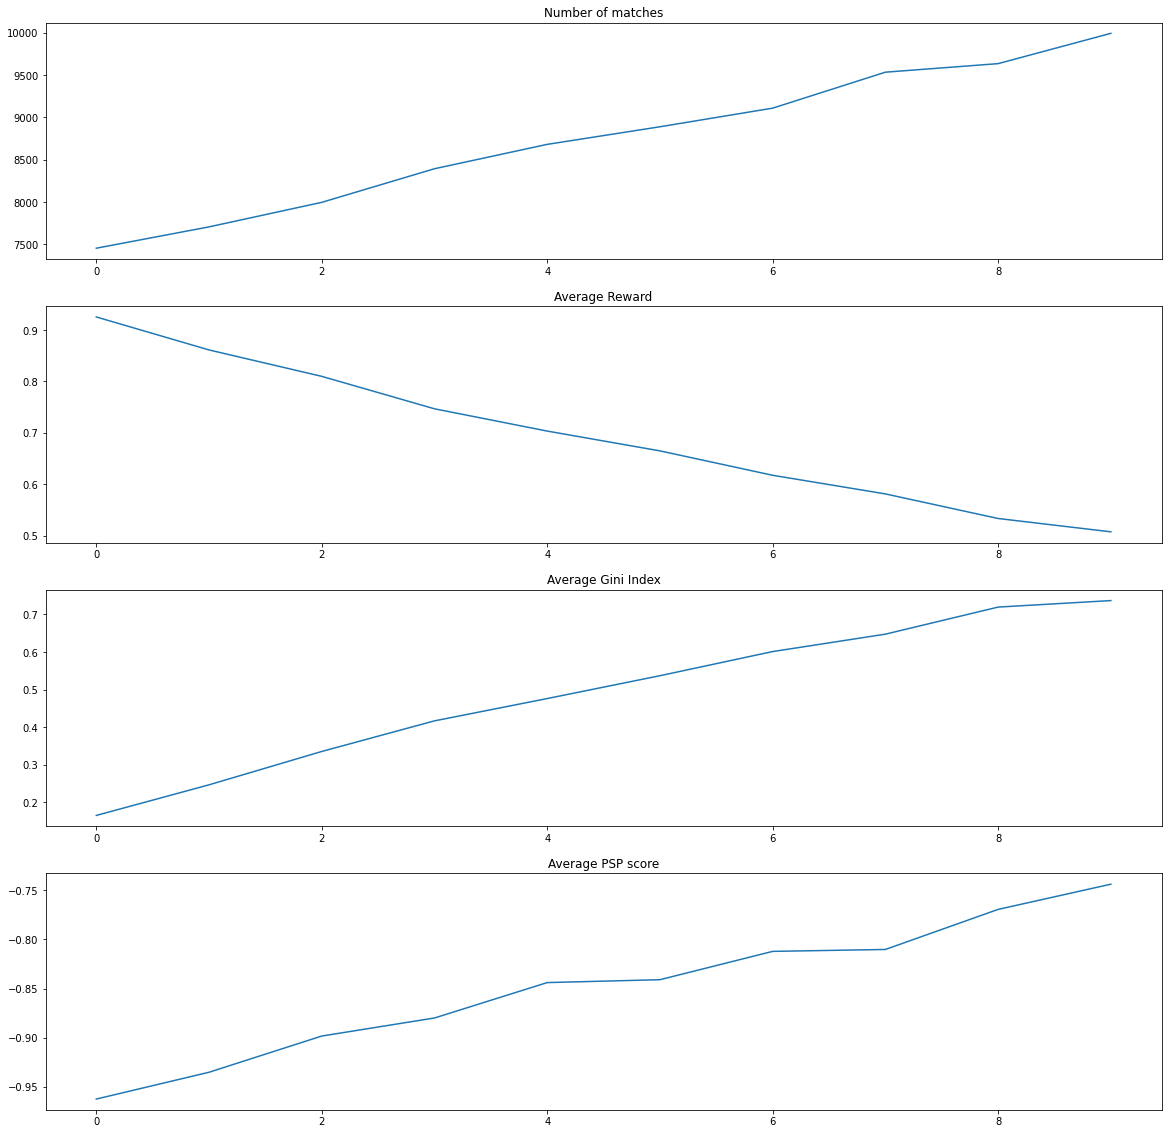

In [27]:
tuneHyperParameter(EpsGreedy)

In [51]:
class DecayingEpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, decay, Q0=np.inf):
        epsilon = 1.0
        super().__init__(n_arms)
        if not (epsilon >= 0 and epsilon <= 1):
            raise ValueError("`epsilon` must be a number in [0,1]")
        if not type(epsilon) == float:
            raise TypeError("`epsilon` must be float")
        if not type(Q0) == float:
            raise TypeError("`Q0` must be a float number or default value 'np.inf'")
            
        self.decay = decay
        self.epsilon = epsilon
        self.q = np.full(n_arms, Q0)      # initialise q values
        self.rewards = np.zeros(n_arms)     # keep the total rewards per arm
        self.clicks = np.zeros(n_arms)      # count the pulled rounds per arm
    
    # select a random arm to explore or a arm with best rewards to exploit, then return the arm 
    def play(self, context=None):
        super().play(context)
        if np.random.random_sample() <= self.epsilon:           #explore
            arm = np.random.randint(0,self.n_arms) 
        else:
            arm = break_tie(self.q)
        return arm 
    
    # update values
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += self.reward
        self.q[arm] = self.rewards[arm] / self.clicks[arm]
        self.epsilon = np.max(self.decay*self.epsilon, 0.05)
        

201632  total lines
9927  matches
0.510526845975622  Average reward
0.7396661913851426  Average Gini Index
-0.7483032649258633  Average PSP
0.9054977410572242


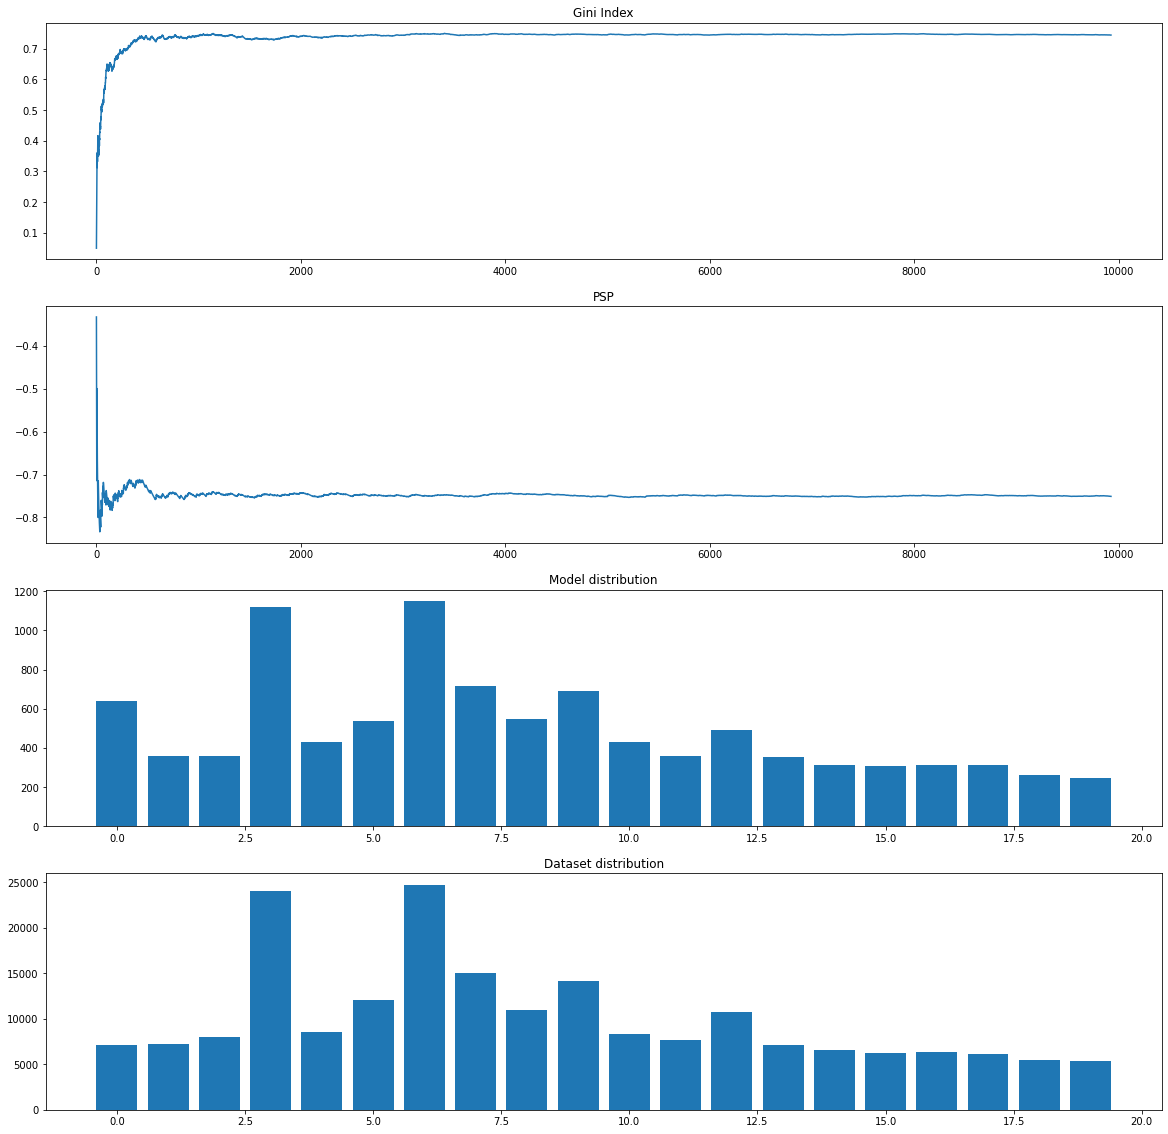

In [54]:
mab = DecayingEpsGreedy(20, 0.99999) 
results_EpsGreedy, dist, psp = offlineEvaluate(mab, arms, rewards, contexts, None, 0)
evaluateMab(results_EpsGreedy, dist, psp)
print(mab.epsilon)

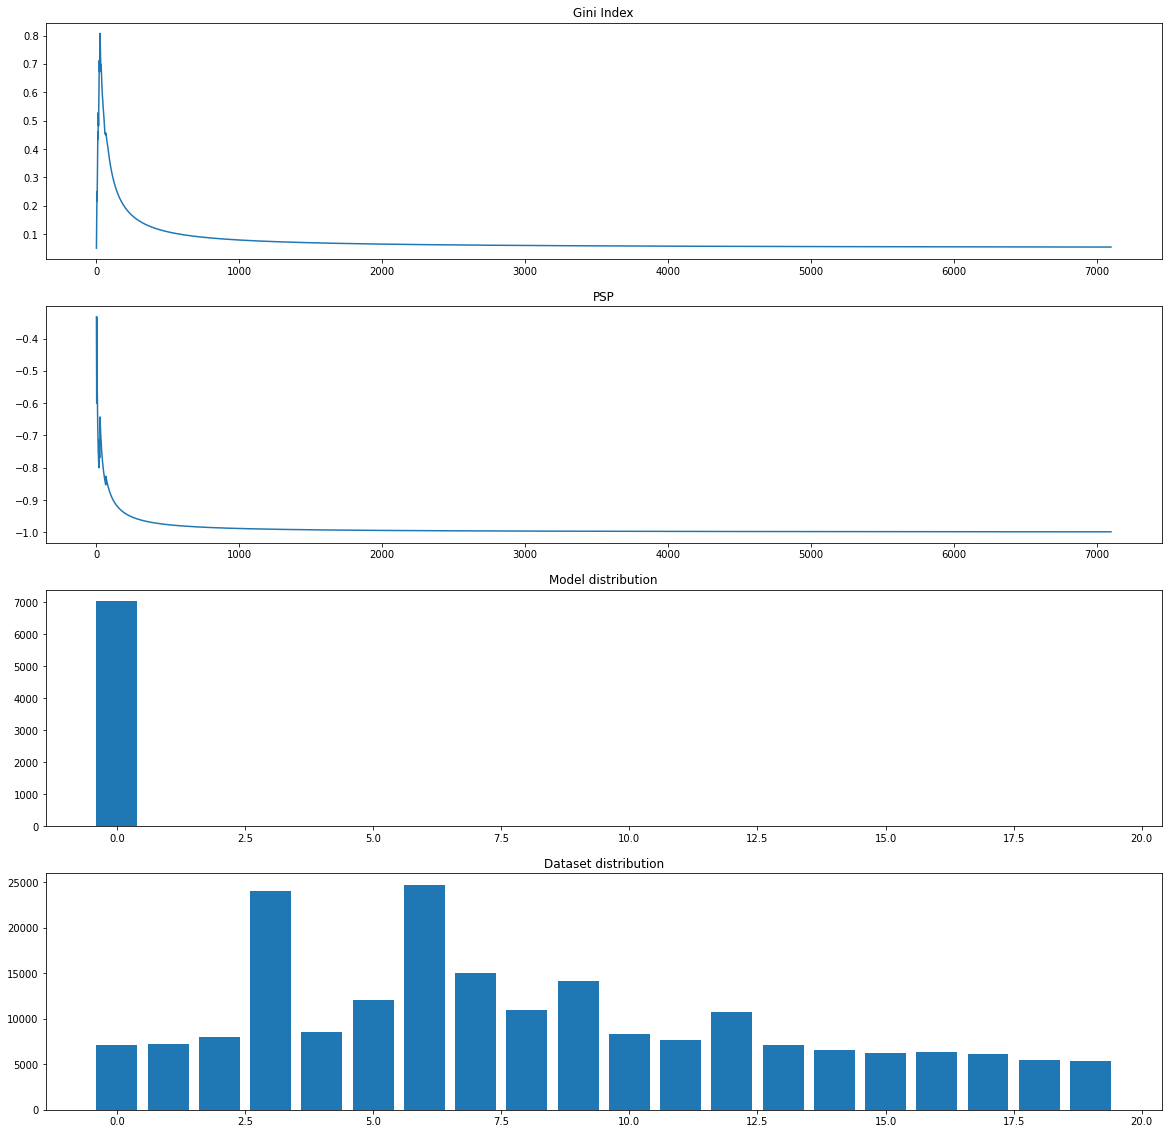

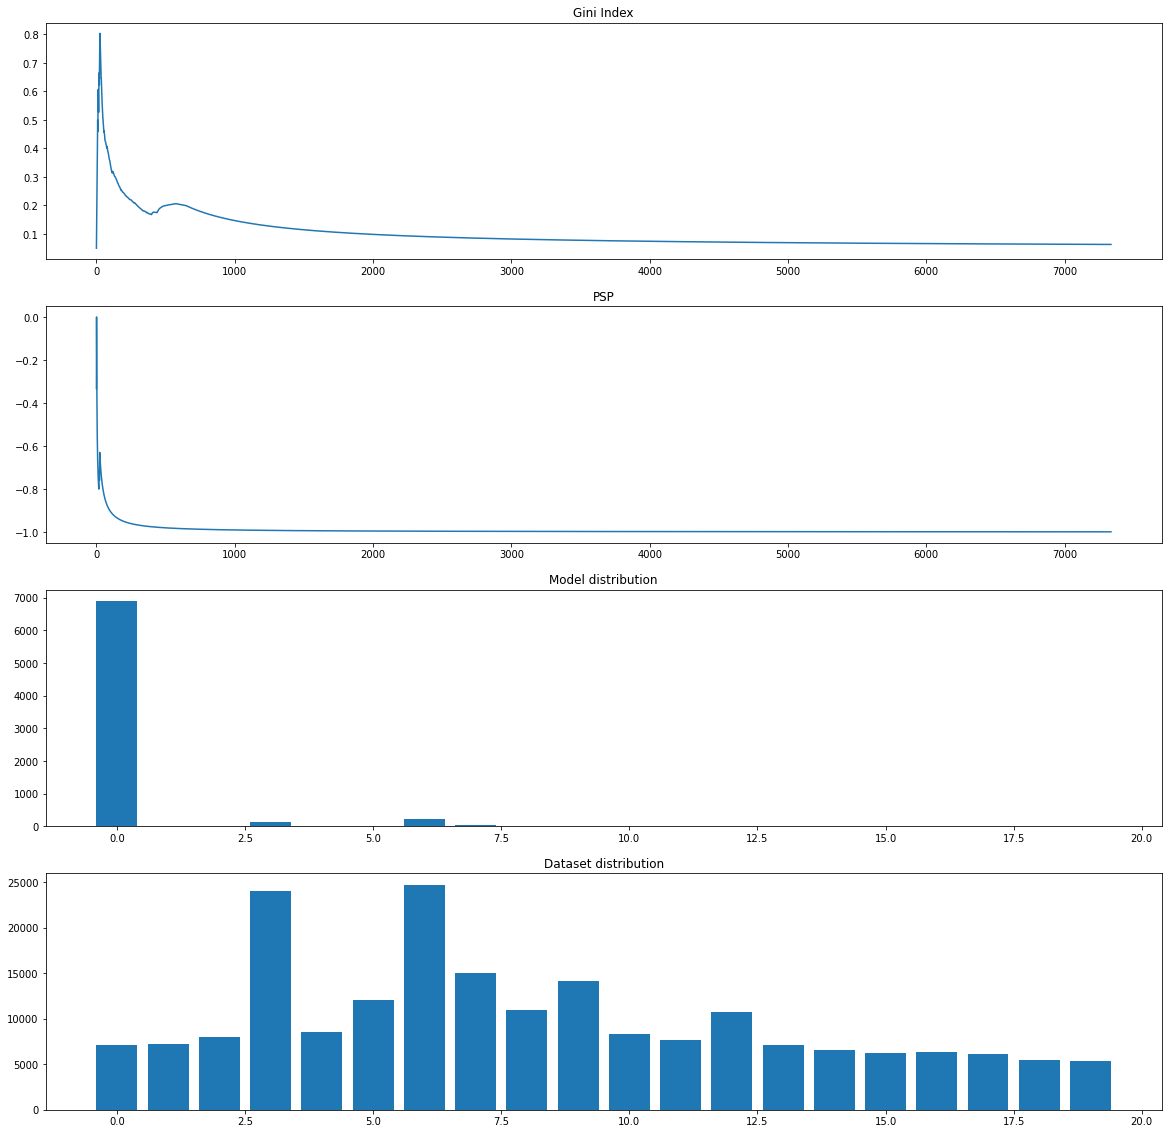

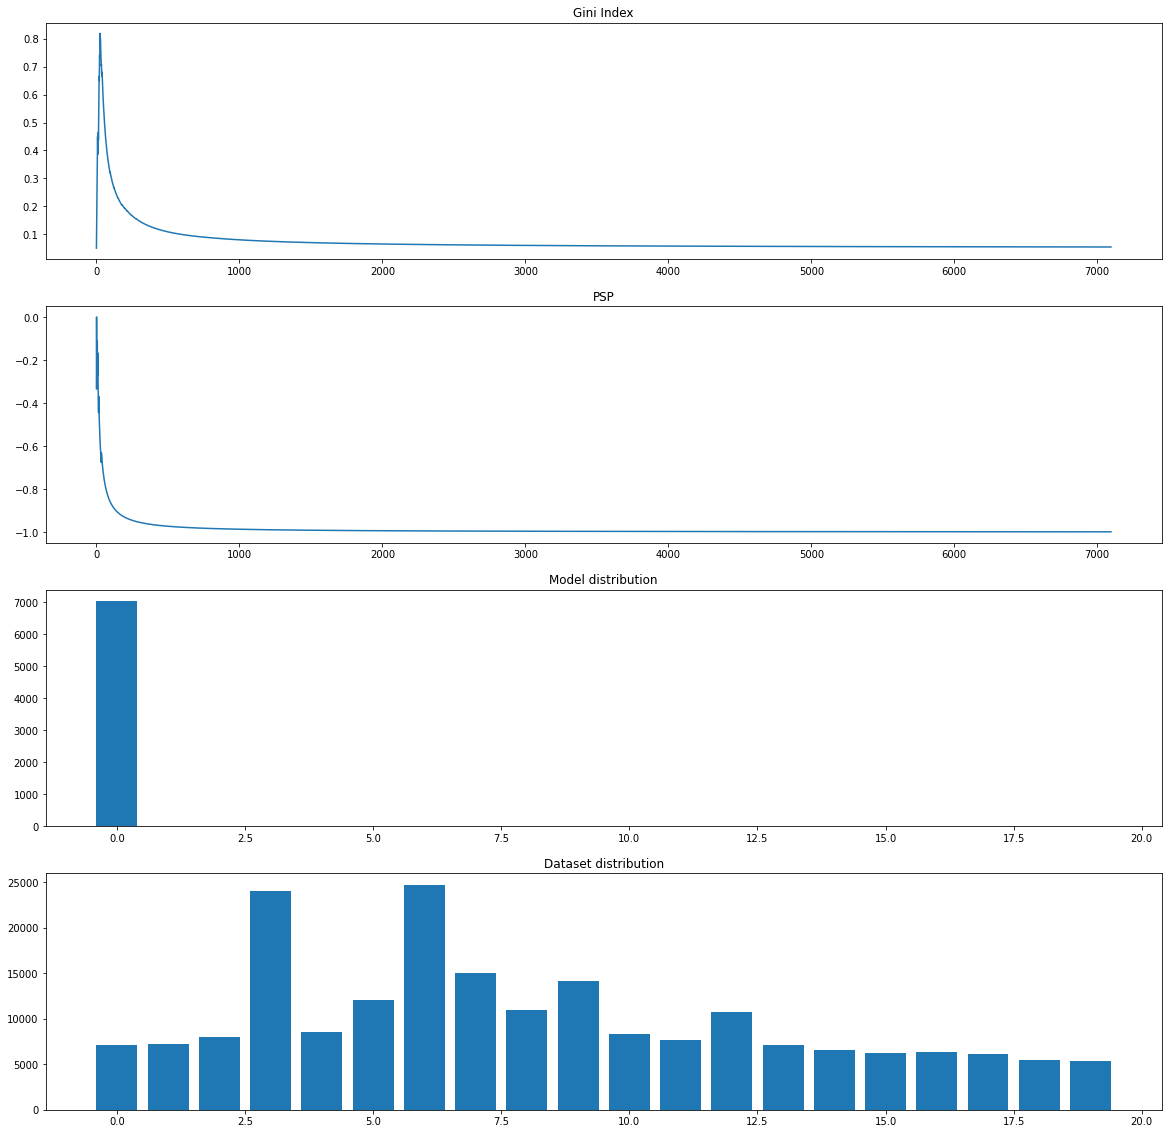

In [61]:
output = []
for i in range(3):
    name = "EpsGreedy"
    mab = EpsGreedy(20, 0.99999) 
    results, dist, psp = offlineEvaluate(mab, arms, rewards, contexts, None, i)
    fig, axs = plt.subplots(4,1, sharex=False, figsize=(20,20))
    axs[0].plot(results[:, 2])
    axs[0].title.set_text("Gini Index")
    axs[1].plot(results[:, 3])
    axs[1].title.set_text("PSP")
    axs[2].bar(np.arange(20), dist) 
    axs[2].title.set_text("Model distribution")
    axs[3].bar(np.arange(20), datadist) 
    axs[3].title.set_text("Dataset distribution")
    fig.savefig(name+str(i)+".jpg",  bbox_inches="tight")
    output.append((results_EpsGreedy, dist, psp))
with open(name, 'wb') as fp:
    pickle.dump(output, fp)